# Imports

In [1]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input, LSTM, Dropout
from keras.layers import LSTM, Input, Bidirectional
from keras.callbacks import ModelCheckpoint
import h5py

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (18,10)

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Supporting Functions

In [2]:
def print_distribution(df, labels_column_name):
    n = df.shape[0]
    print("{} labels frequency:".format(labels_column_name))
    print("Value\tCount\tPercent")
    indeces = df[labels_column_name].value_counts().index.tolist()
    counts = df[labels_column_name].value_counts().tolist()
    for val, count in zip(indeces, counts):
        print("{}\t{}\t{}%".format(val, count, (count / float(n)) * 100))
    
def get_max_words(text_arr):
    max_words = 0
    for line in text_arr:
        num_words = len(line.split())
        if num_words > max_words:
            max_words = num_words
    return max_words

# Load data

In [3]:
# Load in the csv data
reddit_train_df = pd.read_csv("../../data/reddit/labeled/score10_all_sub_labeled_train.csv", index_col=0)
reddit_test_df = pd.read_csv("../../data/reddit/labeled/score10_all_sub_labeled_dev.csv", index_col=0)

# Data setup

Max number of words per post: 78

Getting x_train, y_train, x_test, and y_test...
102991 train sequences
9353 test sequences
----------------------------


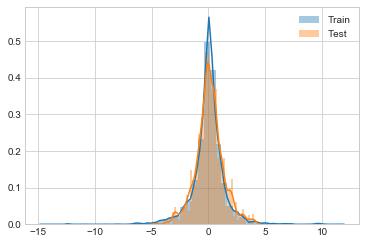

In [4]:
# Determine max post length
max_words_train = get_max_words(reddit_train_df.title.values)
max_words_test = get_max_words(reddit_test_df.title.values)
max_words = max(max_words_train, max_words_test)
print("Max number of words per post: {}".format(max_words))

# Label and title columns in datasets
LABEL_1HR, LABEL_2HR, LABEL_6HR, LABEL_12HR, LABEL_24HR = \
    '1hr_change', '2hr_change', '6hr_change', '12hr_change', '24hr_change'
TEXT_COL = 'title'

# Split into x_train and y_train
print('\nGetting x_train, y_train, x_test, and y_test...')
(x_train, y_train_1hr, y_train_2hr, y_train_6hr, y_train_12hr, y_train_24hr) = \
    reddit_train_df[TEXT_COL].values, reddit_train_df[LABEL_1HR], reddit_train_df[LABEL_2HR], \
    reddit_train_df[LABEL_6HR], reddit_train_df[LABEL_12HR], reddit_train_df[LABEL_24HR]

m_train = x_train.shape[0]
y_train_1hr = y_train_1hr.values.reshape((m_train, 1))
y_train_2hr = y_train_2hr.values.reshape((m_train, 1))
y_train_6hr = y_train_6hr.values.reshape((m_train, 1))
y_train_12hr = y_train_12hr.values.reshape((m_train, 1))
y_train_24hr = y_train_24hr.values.reshape((m_train, 1))
    
(x_test, y_test_1hr, y_test_2hr, y_test_6hr, y_test_12hr, y_test_24hr) = \
    reddit_test_df[TEXT_COL].values, reddit_test_df[LABEL_1HR], reddit_test_df[LABEL_2HR], \
    reddit_test_df[LABEL_6HR], reddit_test_df[LABEL_12HR], reddit_test_df[LABEL_24HR]

m_test = x_test.shape[0]
y_test_1hr = y_test_1hr.values.reshape((m_test, 1))
y_test_2hr = y_test_2hr.values.reshape((m_test, 1))
y_test_6hr = y_test_6hr.values.reshape((m_test, 1))
y_test_12hr = y_test_12hr.values.reshape((m_test, 1))
y_test_24hr = y_test_24hr.values.reshape((m_test, 1)) 

# Print info about train and test
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print("----------------------------")

# Plot distributions of labels
sns.set_style("whitegrid")
sns.distplot(reddit_train_df[LABEL_1HR].values, label='Train')
sns.distplot(reddit_test_df[LABEL_1HR].values, label='Test')
plt.legend()

# Model setup (part 1/3)

In [5]:
# Set hyperparameters
max_features = 200000 # Num words in our vocabulary 
maxlen = max_words  # cut texts after this number of words
batch_size = 32  # Mini-batch size
num_epochs = 5 

# Train tokenizer to create a vocabulary of words
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

# Vectorize each headline
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Update x_train and x_test to be 'sequences' of data
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = sequence.pad_sequences(test_sequences, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)  

Pad sequences (samples x time)
x_train shape: (102991, 78)
x_test shape: (9353, 78)


# Model setup (part 2/3)

In [6]:
# Choose embedding layer to use (pre-trained word2vec or custom)
#EMBEDDING_TYPE = "pretrain"
#EMBEDDING_TYPE = "custom1"
EMBEDDING_TYPE = "custom2"

# If using pre-trained word2vec
if EMBEDDING_TYPE == "pretrain":
    EMBEDDING_FILE = "../../data/embeddings/GoogleNews-vectors-negative300.bin"
    EMBEDDING_DIM = 300 
    word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

# If using custom word2vec (continuous bag)
elif EMBEDDING_TYPE == "custom1":
    EMBEDDING_FILE = "../word2vec/crypto-word2vec-all-200.bin"
    EMBEDDING_DIM = 200
    word2vec = KeyedVectors.load(EMBEDDING_FILE)

# If using custom word2vec (skipgram)
elif EMBEDDING_TYPE == "custom2":
    EMBEDDING_FILE = "../word2vec/crypto-word2vec-skipgram-all-200.bin"
    EMBEDDING_DIM = 200
    word2vec = KeyedVectors.load(EMBEDDING_FILE)
    
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
        
embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=False) 

# Model setup (part 3/3)

In [7]:
# Get the actual embeddings
sequence_input = Input(shape=(maxlen,), dtype='int32')
embeddings = embedding_layer(sequence_input)

# Construct the model (attempt 1 - didn't work)
#X = LSTM(128, return_sequences=True)(embeddings)
#X = Dropout(0.5)(X)
#X = LSTM(128, return_sequences=False)(X)
#X = Dropout(0.5)(X)
#X = Dense(1, activation='sigmoid')(X)

# Construct the model (attempt 1 - didn't work)
X = Bidirectional(LSTM(128, return_sequences=False))(embeddings)
X = Dense(5)(X)

# Select y labels
y_train = np.concatenate((y_train_1hr, y_train_2hr, y_train_6hr, y_train_12hr, y_train_24hr), axis=1)
y_test = np.concatenate((y_test_1hr, y_test_2hr, y_test_6hr, y_test_12hr, y_test_24hr), axis=1)

# Run BTC for 5 epochs

In [8]:
# Define the BTC model
model = Model(inputs=sequence_input, outputs=X)

# Compile the BTC model
model.summary()
model.compile(loss='mean_squared_error', 
                    optimizer='adam', 
                    metrics=['accuracy'])

# Setup model checkpoint
checkpoint_5 = ModelCheckpoint("checkpoints/reddit-5epochs.hdf5")

# Run the BTC model
model.fit(x_train, 
          y_train, 
          batch_size=batch_size, 
          epochs=num_epochs, 
          validation_data=(x_test, y_test),
          callbacks=[checkpoint_5])

score, acc = model.evaluate(x_test, 
                                y_test,
                                batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 78)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 78, 200)           7844000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 8,182,181
Trainable params: 338,181
Non-trainable params: 7,844,000
_________________________________________________________________
Train on 102991 samples, validate on 9353 samples
Epoch 1/5
102991/102991 [==============================] - 259s 3ms/step - loss: 15.8960 - acc: 0.3868 - val_loss: 10.7890 - val_acc: 0.4570
Epoch 2/5
102991/102991 [==============================] - 250s 2ms

# Run BTC model for 15 more epochs

In [9]:
# Setup model checkpoints
checkpoint_10 = ModelCheckpoint("checkpoints/reddit-10epochs.hdf5")
checkpoint_15 = ModelCheckpoint("checkpoints/reddit-15epochs.hdf5")
checkpoint_20 = ModelCheckpoint("checkpoints/reddit-20epochs.hdf5")

# Run the BTC model 5 more epochs
model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=(x_test, y_test),
          callbacks=[checkpoint_10])

score, acc = model.evaluate(x_test,
                            y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Run the BTC model 5 more epochs
model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=(x_test, y_test),
          callbacks=[checkpoint_15])

score, acc = model.evaluate(x_test,
                            y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Run the BTC model 5 more epochs
model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=(x_test, y_test),
          callbacks=[checkpoint_20])

score, acc = model.evaluate(x_test,
                            y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


Train on 102991 samples, validate on 9353 samples
Epoch 1/5
102991/102991 [==============================] - 262s 3ms/step - loss: 15.6429 - acc: 0.3589 - val_loss: 11.0011 - val_acc: 0.3819
Epoch 2/5
102991/102991 [==============================] - 266s 3ms/step - loss: 15.4735 - acc: 0.3526 - val_loss: 11.1096 - val_acc: 0.3800
Epoch 3/5
102991/102991 [==============================] - 268s 3ms/step - loss: 15.2067 - acc: 0.3516 - val_loss: 11.2850 - val_acc: 0.3557
Epoch 4/5
102991/102991 [==============================] - 256s 2ms/step - loss: 14.8090 - acc: 0.3522 - val_loss: 11.9347 - val_acc: 0.3303
Epoch 5/5
9353/9353 [==============================] - 7s 698us/step
Test score: 12.45378805158942
Test accuracy: 0.3021490430973385
Train on 102991 samples, validate on 9353 samples
Epoch 1/5
102991/102991 [==============================] - 261s 3ms/step - loss: 13.8368 - acc: 0.3631 - val_loss: 12.5773 - val_acc: 0.3154
Epoch 2/5
102991/102991 [==============================] - 268

# Load model checkpoints

In [12]:
# Choose which checkpoints to load (pre-trained word2vec or custom)
CHECKPOINT_PATH = 'checkpoints/'
#CHECKPOINT_PATH = 'checkpoints/pretrained_word2vec/'
#CHECKPOINT_PATH = 'checkpoints/custom1_word2vec/'

###################################################################
# After 5 epochs
###################################################################
model_5 = Model(inputs=sequence_input, outputs=X)
model_5.load_weights(CHECKPOINT_PATH + "reddit-5epochs.hdf5")
model_5.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['accuracy'])
score_5, acc_5 = model_5.evaluate(x_test,
                                  y_test,
                                  batch_size=batch_size)
predictions_5 = model_5.predict(x_test)
print('Test score:', score_5)
print('Test accuracy:', acc_5)
                     
###################################################################
# After 10 epochs
###################################################################
model_10 = Model(inputs=sequence_input, outputs=X)
model_10.load_weights(CHECKPOINT_PATH + "reddit-10epochs.hdf5")
model_10.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_10, acc_10 = model_10.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_10 = model_10.predict(x_test)
print('Test score:', score_10)
print('Test accuracy:', acc_10)

###################################################################
# After 15 epochs
###################################################################
model_15 = Model(inputs=sequence_input, outputs=X)
model_15.load_weights(CHECKPOINT_PATH + "reddit-15epochs.hdf5")
model_15.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_15, acc_15 = model_15.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_15 = model_15.predict(x_test)
print('Test score:', score_15)
print('Test accuracy:', acc_15)

###################################################################
# After 20 epochs
###################################################################
model_20 = Model(inputs=sequence_input, outputs=X)
model_20.load_weights(CHECKPOINT_PATH + "reddit-20epochs.hdf5")
model_20.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_20, acc_20 = model_20.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_20 = model_20.predict(x_test)
print('Test score:', score_20)
print('Test accuracy:', acc_20)

9353/9353 [==============================] - 7s 723us/step
Test score: 10.957711746917967
Test accuracy: 0.4164439217371379
9353/9353 [==============================] - 7s 725us/step
Test score: 12.45378805158942
Test accuracy: 0.3021490430973385
9353/9353 [==============================] - 6s 678us/step
Test score: 14.270616002380052
Test accuracy: 0.3033251363294565
9353/9353 [==============================] - 6s 677us/step
Test score: 15.990437723896179
Test accuracy: 0.29968993905858027


# Run BTC model for 10 more epochs

In [10]:
# Setup model checkpoints
checkpoint_25 = ModelCheckpoint("checkpoints/reddit-25epochs.hdf5")
checkpoint_30 = ModelCheckpoint("checkpoints/reddit-30epochs.hdf5")

# Load model trained for 20 epochs
#model = Model(inputs=sequence_input, outputs=X)
#model.load_weights("checkpoints/reddit-20epochs.hdf5")
#model.compile(loss='mean_squared_error',
#                  optimizer='adam',
#                  metrics=['accuracy'])

# Run the model 5 more epochs
model.fit(x_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=num_epochs, 
              validation_data=(x_test, y_test),
              callbacks=[checkpoint_25])
score, acc = model.evaluate(x_test, 
                                y_test,
                                batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Run the model 5 more epochs
model.fit(x_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=num_epochs, 
              validation_data=(x_test, y_test),
              callbacks=[checkpoint_30])
score, acc = model.evaluate(x_test, 
                                y_test,
                                batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train on 102991 samples, validate on 9353 samples
Epoch 1/5
102991/102991 [==============================] - 256s 2ms/step - loss: 9.6124 - acc: 0.4110 - val_loss: 15.7960 - val_acc: 0.3043
Epoch 2/5
102991/102991 [==============================] - 252s 2ms/step - loss: 9.3754 - acc: 0.4153 - val_loss: 16.4191 - val_acc: 0.3038
Epoch 3/5
102991/102991 [==============================] - 253s 2ms/step - loss: 9.1449 - acc: 0.4181 - val_loss: 16.4449 - val_acc: 0.2946
Epoch 4/5
102991/102991 [==============================] - 252s 2ms/step - loss: 8.9141 - acc: 0.4202 - val_loss: 16.6126 - val_acc: 0.3077
Epoch 5/5
9353/9353 [==============================] - 6s 679us/step
Test score: 16.720428319356156
Test accuracy: 0.300117609324805
Train on 102991 samples, validate on 9353 samples
Epoch 1/5
102991/102991 [==============================] - 251s 2ms/step - loss: 8.5499 - acc: 0.4274 - val_loss: 17.4845 - val_acc: 0.3032
Epoch 2/5
102991/102991 [==============================] - 259s 3ms

# Run BTC model for 20 more epochs

In [11]:
# Setup model checkpoints
checkpoint_35 = ModelCheckpoint("checkpoints/reddit-35epochs.hdf5")
checkpoint_40 = ModelCheckpoint("checkpoints/reddit-40epochs.hdf5")
checkpoint_45 = ModelCheckpoint("checkpoints/reddit-45epochs.hdf5")
checkpoint_50 = ModelCheckpoint("checkpoints/reddit-50epochs.hdf5")

# Load model trained for 30 epochs
#model = Model(inputs=sequence_input, outputs=X)
#model.load_weights("checkpoints/reddit-30epochs.hdf5")
#model.compile(loss='mean_squared_error',
#                   optimizer='adam',
#                   metrics=['accuracy'])

# Run the model 5 more epochs
model.fit(x_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=num_epochs, 
              validation_data=(x_test, y_test),
              callbacks=[checkpoint_35])
score, acc = model.evaluate(x_test, 
                                y_test,
                                batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Run the model 5 more epochs
model.fit(x_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=num_epochs, 
              validation_data=(x_test, y_test),
              callbacks=[checkpoint_40])
score, acc = model.evaluate(x_test, 
                                y_test,
                                batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Run the model 5 more epochs
model.fit(x_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=num_epochs, 
              validation_data=(x_test, y_test),
              callbacks=[checkpoint_45])
score, acc = model.evaluate(x_test, 
                                y_test,
                                batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Run the model 5 more epochs
model.fit(x_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=num_epochs, 
              validation_data=(x_test, y_test),
              callbacks=[checkpoint_50])
score, acc = model.evaluate(x_test, 
                                y_test,
                                batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train on 102991 samples, validate on 9353 samples
Epoch 1/5
102991/102991 [==============================] - 251s 2ms/step - loss: 7.8908 - acc: 0.4352 - val_loss: 17.5821 - val_acc: 0.3054
Epoch 2/5
102991/102991 [==============================] - 253s 2ms/step - loss: 7.7932 - acc: 0.4380 - val_loss: 17.9000 - val_acc: 0.3059
Epoch 3/5
102991/102991 [==============================] - 262s 3ms/step - loss: 7.6643 - acc: 0.4401 - val_loss: 18.0463 - val_acc: 0.2987
Epoch 4/5
102991/102991 [==============================] - 264s 3ms/step - loss: 7.5628 - acc: 0.4404 - val_loss: 18.0680 - val_acc: 0.3004
Epoch 5/5
9353/9353 [==============================] - 6s 669us/step
Test score: 18.058835946365203
Test accuracy: 0.3002245268905646
Train on 102991 samples, validate on 9353 samples
Epoch 1/5
102991/102991 [==============================] - 256s 2ms/step - loss: 7.4087 - acc: 0.4441 - val_loss: 18.2692 - val_acc: 0.3045
Epoch 2/5
102991/102991 [==============================] - 259s 3m

# Load model checkpoints

In [13]:
###################################################################
# After 25 epochs
###################################################################
model_25 = Model(inputs=sequence_input, outputs=X)
model_25.load_weights(CHECKPOINT_PATH + "reddit-25epochs.hdf5")
model_25.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_25, acc_25 = model_25.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_25 = model_25.predict(x_test)
print('Test score:', score_25)
print('Test accuracy:', acc_25)
                     
###################################################################
# After 30 epochs
###################################################################
model_30 = Model(inputs=sequence_input, outputs=X)
model_30.load_weights(CHECKPOINT_PATH + "reddit-30epochs.hdf5")
model_30.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_30, acc_30 = model_30.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_30 = model_30.predict(x_test)
print('Test score:', score_30)
print('Test accuracy:', acc_30)

###################################################################
# After 35 epochs
###################################################################
model_35 = Model(inputs=sequence_input, outputs=X)
model_35.load_weights(CHECKPOINT_PATH + "reddit-35epochs.hdf5")
model_35.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_35, acc_35 = model_35.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_35 = model_35.predict(x_test)
print('Test score:', score_35)
print('Test accuracy:', acc_35)

###################################################################
# After 40 epochs
###################################################################
model_40 = Model(inputs=sequence_input, outputs=X)
model_40.load_weights(CHECKPOINT_PATH + "reddit-40epochs.hdf5")
model_40.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_40, acc_40 = model_40.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_40 = model_40.predict(x_test)
print('Test score:', score_40)
print('Test accuracy:', acc_40)

###################################################################
# After 45 epochs
###################################################################
model_45 = Model(inputs=sequence_input, outputs=X)
model_45.load_weights(CHECKPOINT_PATH + "reddit-45epochs.hdf5")
model_45.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_45, acc_45 = model_45.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_45 = model_45.predict(x_test)
print('Test score:', score_45)
print('Test accuracy:', acc_45)

###################################################################
# After 50 epochs
###################################################################
model_50 = Model(inputs=sequence_input, outputs=X)
model_50.load_weights(CHECKPOINT_PATH + "reddit-50epochs.hdf5")
model_50.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['accuracy'])
score_50, acc_50 = model_50.evaluate(x_test,
                                     y_test,
                                     batch_size=batch_size)
predictions_50 = model_50.predict(x_test)
print('Test score:', score_50)
print('Test accuracy:', acc_50)

9353/9353 [==============================] - 7s 698us/step
Test score: 16.720428319356156
Test accuracy: 0.300117609324805
9353/9353 [==============================] - 6s 686us/step
Test score: 17.397529930682484
Test accuracy: 0.3023628782216883
9353/9353 [==============================] - 7s 704us/step
Test score: 18.058835946365203
Test accuracy: 0.3002245268905646
9353/9353 [==============================] - 6s 683us/step
Test score: 18.360146574421922
Test accuracy: 0.3070672511501604
9353/9353 [==============================] - 6s 690us/step
Test score: 18.97454126105772
Test accuracy: 0.2922057093996473
9353/9353 [==============================] - 6s 691us/step
Test score: 19.038846643317974
Test accuracy: 0.29402330803030585


# Evaluate the results

### First, organize predictions from each number of epochs trained and print summary

In [14]:
###############################################################
# 1/2: CHANGE if more epochs added
###############################################################

# To iterate through training epochs
epochs = ['05 epochs', '10 epochs', '15 epochs', '20 epochs', \
          '25 epochs', '30 epochs', '35 epochs', '40 epochs', \
          '45 epochs', '50 epochs']

# Object 1: To zip all dfs together later
all_dfs = (reddit_test_df.values, \
           predictions_5, \
           predictions_10, \
           predictions_15, \
           predictions_20, \
           predictions_25, \
           predictions_30, \
           predictions_35, \
           predictions_40, \
           predictions_45, \
           predictions_50)

# Object 2: To print below
all_predictions = [('AFTER 5 EPOCHS TRAINING', predictions_5),
                   ('AFTER 10 EPOCHS TRAINING', predictions_10),
                   ('AFTER 15 EPOCHS TRAINING', predictions_15),
                   ('AFTER 20 EPOCHS TRAINING', predictions_20),
                   ('AFTER 25 EPOCHS TRAINING', predictions_25),
                   ('AFTER 30 EPOCHS TRAINING', predictions_30), 
                   ('AFTER 35 EPOCHS TRAINING', predictions_35), 
                   ('AFTER 40 EPOCHS TRAINING', predictions_40), 
                   ('AFTER 45 EPOCHS TRAINING', predictions_45), 
                   ('AFTER 50 EPOCHS TRAINING', predictions_50)]

###############################################################
# 2/2: DON'T CHANGE if more epochs added
###############################################################

# Loop through each set and print summary\n",
for description, prediction in all_predictions:
    pred_1hr, summary_1hr = prediction[:,0], pd.Series(np.squeeze(prediction[:,0])).describe()
    pred_2hr, summary_2hr = prediction[:,1], pd.Series(np.squeeze(prediction[:,1])).describe()
    pred_6hr, summary_6hr = prediction[:,2], pd.Series(np.squeeze(prediction[:,2])).describe()
    pred_12hr, summary_12hr = prediction[:,3], pd.Series(np.squeeze(prediction[:,3])).describe()
    pred_24hr, summary_24hr = prediction[:,4], pd.Series(np.squeeze(prediction[:,4])).describe()

    print('\n%s' % description)
    print('[+01 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_1hr['mean'], summary_1hr['min'], summary_1hr['25%'], summary_1hr['75%'], summary_1hr['max']))
    print('[+02 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_2hr['mean'], summary_2hr['min'], summary_2hr['25%'], summary_2hr['75%'], summary_2hr['max']))
    print('[+06 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_6hr['mean'], summary_6hr['min'], summary_6hr['25%'], summary_6hr['75%'], summary_6hr['max']))
    print('[+12 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_12hr['mean'], summary_12hr['min'], summary_12hr['25%'], summary_12hr['75%'], summary_12hr['max']))
    print('[+24 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_24hr['mean'], summary_24hr['min'], summary_24hr['25%'], summary_24hr['75%'], summary_24hr['max']))


AFTER 5 EPOCHS TRAINING
[+01 hr]	Mean: 0.0084	Min: -0.4690	25%: -0.0321	75%: 0.0529	Max: 0.4223
[+02 hr]	Mean: 0.0336	Min: -0.7148	25%: -0.0201	75%: 0.0944	Max: 0.4444
[+06 hr]	Mean: 0.0599	Min: -2.1238	25%: -0.0812	75%: 0.2267	Max: 1.5718
[+12 hr]	Mean: 0.2345	Min: -2.7856	25%: 0.0227	75%: 0.4720	Max: 2.3488
[+24 hr]	Mean: 0.6168	Min: -2.7412	25%: 0.2774	75%: 0.9544	Max: 3.6503

AFTER 10 EPOCHS TRAINING
[+01 hr]	Mean: 0.0496	Min: -0.7721	25%: -0.0558	75%: 0.1489	Max: 1.0781
[+02 hr]	Mean: 0.0453	Min: -1.5298	25%: -0.1366	75%: 0.2278	Max: 1.9591
[+06 hr]	Mean: 0.0415	Min: -5.3742	25%: -0.4493	75%: 0.5298	Max: 5.3796
[+12 hr]	Mean: 0.1427	Min: -8.0226	25%: -0.6229	75%: 0.9021	Max: 9.2743
[+24 hr]	Mean: 0.2938	Min: -10.7361	25%: -0.8735	75%: 1.4381	Max: 12.8430

AFTER 15 EPOCHS TRAINING
[+01 hr]	Mean: 0.0316	Min: -1.1941	25%: -0.1275	75%: 0.1864	Max: 1.8499
[+02 hr]	Mean: 0.0210	Min: -2.2883	25%: -0.2595	75%: 0.3021	Max: 3.3781
[+06 hr]	Mean: 0.1260	Min: -6.3656	25%: -0.6307	75%: 0.8991

### Then, check prediction performance:
- How many of the largest (positive) ACTUAL price changes did we PREDICT correctly
- How many of the largest (negative) ACTUAL price changes did we PREDICT correctly

### Setup

In [16]:
# Prediction times
prediction_times = ['1hr', '2hr', '6hr', '12hr', '24hr']

# Indices of columns in test df and prediction dfs
actual_columns = {'date' : 0, 'title' : 4, '1hr' : 5, '2hr' : 6, '6hr' : 7, '12hr' : 8, '24hr' : 9}
pred_columns = {'1hr' : 0, '2hr' : 1, '6hr' : 2, '12hr' : 3, '24hr' : 4}

# Set cutoffs to only consider largest (positive) price changes
pos_percent = 0.80 # Means will consider top 20%
pos_1hr = pd.Series(np.squeeze(reddit_test_df['1hr_change'])).quantile(pos_percent)
pos_2hr = pd.Series(np.squeeze(reddit_test_df['2hr_change'])).quantile(pos_percent)
pos_6hr = pd.Series(np.squeeze(reddit_test_df['6hr_change'])).quantile(pos_percent)
pos_12hr = pd.Series(np.squeeze(reddit_test_df['12hr_change'])).quantile(pos_percent)
pos_24hr = pd.Series(np.squeeze(reddit_test_df['24hr_change'])).quantile(pos_percent)
pos_cutoffs = {'1hr' : pos_1hr, '2hr' : pos_2hr, '6hr' : pos_6hr, '12hr' : pos_12hr, '24hr' : pos_24hr} 

# Set cutoffs to only consider largest (negative) price changes
neg_percent = 0.20 # Means will consider bottom 20%
neg_1hr = pd.Series(np.squeeze(reddit_test_df['1hr_change'])).quantile(neg_percent)
neg_2hr = pd.Series(np.squeeze(reddit_test_df['2hr_change'])).quantile(neg_percent)
neg_6hr = pd.Series(np.squeeze(reddit_test_df['6hr_change'])).quantile(neg_percent)
neg_12hr = pd.Series(np.squeeze(reddit_test_df['12hr_change'])).quantile(neg_percent)
neg_24hr = pd.Series(np.squeeze(reddit_test_df['24hr_change'])).quantile(neg_percent)
neg_cutoffs = {'1hr' : neg_1hr, '2hr' : neg_2hr, '6hr' : neg_6hr, '12hr' : neg_12hr, '24hr' : neg_24hr} 

# Print
for time in prediction_times:
    print ('[%s] Top cutoff: %.4f, Bottom cutoff: %.4f' % (time, pos_cutoffs[time], neg_cutoffs[time]))

# Initial state of prediction counts
initial_pred_counts = {}
for epoch in epochs:
    initial_pred_counts[epoch] = 0
    
# To keep track of actual changes vs predicted changes (aggregated hourly)
changes = {'1hr':{}, '2hr':{}, '6hr':{}, '12hr':{}, '24hr':{}}
for time in prediction_times:
    for epoch in epochs:
        changes[time][epoch] = []

[1hr] Top cutoff: 0.9864, Bottom cutoff: -0.7630
[2hr] Top cutoff: 1.3951, Bottom cutoff: -1.1409
[6hr] Top cutoff: 2.5950, Bottom cutoff: -1.6548
[12hr] Top cutoff: 3.8299, Bottom cutoff: -2.4704
[24hr] Top cutoff: 6.0746, Bottom cutoff: -2.8883


### Run

In [17]:
###############################################################
# Loop through each prediction time
###############################################################
for time in prediction_times:
       
    # To keep track of (largest positive) counts
    num_actual_above = 0
    num_pred_above, num_pred_positive = initial_pred_counts.copy(), initial_pred_counts.copy()
    per_pred_above, per_pred_positive = initial_pred_counts.copy(), initial_pred_counts.copy() 
    
    # To keep track of (largest negative) counts
    num_actual_below = 0
    num_pred_below, num_pred_negative = initial_pred_counts.copy(), initial_pred_counts.copy()
    per_pred_below, per_pred_negative = initial_pred_counts.copy(), initial_pred_counts.copy() 
    
    # To keep track of cummulative hourly predictions
    total_hours = 1
    preds_tally, correct_hours, per_correct_hours = \
        initial_pred_counts.copy(), initial_pred_counts.copy(), initial_pred_counts.copy()
    current_hour = reddit_test_df.values[0][actual_columns['date']].split(' ')[1].split(':')[0]
    
    # To keep of titles of posts predicted correctly above and below cutoff
    titles_above, titles_below = {}, {}
    for epoch in epochs:
        titles_above[epoch] = []
        titles_below[epoch] = []
        
    #########################################
    # Loop through each row in actual test df and prediction dfs
    #########################################
    for all_items in zip(*all_dfs):
    
        # Separate 
        i, preds = 0, {}
        actual = all_items[i]
        for epoch in epochs:
            i += 1
            preds[epoch] = all_items[i]
                
        # Check if actual value >= top cutoff
        if actual[actual_columns[time]] >= pos_cutoffs[time]:
            # Increment actual count
            num_actual_above += 1
            # Loop through each set of predictions
            for epoch in epochs:
                # If prediction >= cutoff   
                if preds[epoch][pred_columns[time]] >= pos_cutoffs[time]: 
                    # Count
                    num_pred_above[epoch] += 1
                    # Title
                    titles_above[epoch].append \
                        ((actual[actual_columns['title']], 
                         actual[actual_columns[time]], 
                         preds[epoch][pred_columns[time]]))
                # If prediction at least positive   
                if preds[epoch][pred_columns[time]] >= 0: 
                    num_pred_positive[epoch] += 1
    
        # Check if actual value <= bottom cutoff
        if actual[actual_columns[time]] <= neg_cutoffs[time]:
            # Increment actual count
            num_actual_below += 1
            # Loop through each set of predictions
            for epoch in epochs:
                # If prediction >= cutoff   
                if preds[epoch][pred_columns[time]] <= neg_cutoffs[time]: 
                    # Count
                    num_pred_below[epoch] += 1
                    # Title
                    titles_below[epoch].append \
                        ((actual[actual_columns['title']], 
                         actual[actual_columns[time]], 
                         preds[epoch][pred_columns[time]])) 
                # If prediction at least negative   
                if preds[epoch][pred_columns[time]] <= 0: 
                    num_pred_negative[epoch] += 1
    
        # Isolate date of current row
        new_hour = actual[actual_columns['date']].split(' ')[1].split(':')[0]
     
        # If moved to new date
        if not new_hour == current_hour:
            # Check prediction tallys vs actual price changes
            for epoch in epochs:
                if np.sign(preds_tally[epoch]) == np.sign(actual[actual_columns[time]]):
                    correct_hours[epoch] += 1
            # Fill structure to make charts later
            for epoch in epochs:
                changes[time][epoch].append((actual[actual_columns[time]], preds_tally[epoch]))
            # Update total day count, reset tally, change current_day
            total_hours += 1
            preds_tally = initial_pred_counts.copy()
            current_hour = new_hour
    
        # Update prediction tallys
        for epoch in epochs:
            preds_tally[epoch] += preds[epoch][pred_columns[time]]
    
    #########################################          
    # Calculate percentage of correct predictions
    #########################################          
    for epoch in epochs:
        per_pred_above[epoch] = (num_pred_above[epoch] / num_actual_above) * 100
        per_pred_positive[epoch] = (num_pred_positive[epoch] / num_actual_above) * 100   
        per_pred_below[epoch] = (num_pred_below[epoch] / num_actual_below) * 100
        per_pred_negative[epoch] = (num_pred_negative[epoch] / num_actual_below) * 100   
        per_correct_hours[epoch] = (correct_hours[epoch] / total_hours) * 100
        
    #########################################          
    # Print results
    #########################################   
    print ('\n***** PREDICTIONS +%s IN FUTURE *****' % time)
    
    print ('\nNum ACTUAL in top %d%% (change >= %.2f%%): %d' % \
        (100-int(pos_percent*100), pos_cutoffs[time], num_actual_above))           
    for epoch in epochs:
        print ('[%s train] Above cutoff: %d (%.2f%%), Positive: %d (%.2f%%)' % \
            (epoch, num_pred_above[epoch], per_pred_above[epoch], num_pred_positive[epoch], per_pred_positive[epoch]))
        
    print ('\nNum ACTUAL in bottom %d%% (change <= %.2f%%): %d' % \
        (int(neg_percent*100), neg_cutoffs[time], num_actual_below))           
    for epoch in epochs:
        print ('[%s train] Below cutoff: %d (%.2f%%), Negative: %d (%.2f%%)' % \
            (epoch, num_pred_below[epoch], per_pred_below[epoch], num_pred_negative[epoch], per_pred_negative[epoch]))
    
    print ('\nTotal hours in test set: %d' % (total_hours))           
    for epoch in epochs:
        print ('[%s train] Correct aggregated predictions: %d hours (%.2f%%)' % \
            (epoch, correct_hours[epoch], per_correct_hours[epoch]))
     
    '''                    
    print ('\nPost titles correctly predicted ABOVE cutoff:')     
    for epoch in epochs:
        print ('[%s train]' % epoch)
        for title in titles_above[epoch]:
            print ('\t%s\n\tActual: %.2f, Predicted: %.2f' % (title[0], title[1], title[2]))

    print ('\nPost titles correctly predicted BELOW cutoff:')     
    for epoch in epochs:
        print ('[%s train]' % epoch)
        for title in titles_below[epoch]:
            print ('\t%s\n\tActual: %.2f, Predicted: %.2f' % (title[0], title[1], title[2]))      
   '''
                        


***** PREDICTIONS +1hr IN FUTURE *****

Num ACTUAL in top 20% (change >= 0.99%): 1881
[05 epochs train] Above cutoff: 0 (0.00%), Positive: 1007 (53.54%)
[10 epochs train] Above cutoff: 0 (0.00%), Positive: 1142 (60.71%)
[15 epochs train] Above cutoff: 2 (0.11%), Positive: 981 (52.15%)
[20 epochs train] Above cutoff: 12 (0.64%), Positive: 937 (49.81%)
[25 epochs train] Above cutoff: 10 (0.53%), Positive: 869 (46.20%)
[30 epochs train] Above cutoff: 13 (0.69%), Positive: 881 (46.84%)
[35 epochs train] Above cutoff: 20 (1.06%), Positive: 1029 (54.70%)
[40 epochs train] Above cutoff: 19 (1.01%), Positive: 1011 (53.75%)
[45 epochs train] Above cutoff: 17 (0.90%), Positive: 858 (45.61%)
[50 epochs train] Above cutoff: 22 (1.17%), Positive: 857 (45.56%)

Num ACTUAL in bottom 20% (change <= -0.76%): 1881
[05 epochs train] Below cutoff: 0 (0.00%), Negative: 822 (43.70%)
[10 epochs train] Below cutoff: 0 (0.00%), Negative: 731 (38.86%)
[15 epochs train] Below cutoff: 11 (0.58%), Negative: 851 (


***** PREDICTIONS +24hr IN FUTURE *****

Num ACTUAL in top 20% (change >= 6.07%): 1877
[05 epochs train] Above cutoff: 0 (0.00%), Positive: 1613 (85.94%)
[10 epochs train] Above cutoff: 14 (0.75%), Positive: 1038 (55.30%)
[15 epochs train] Above cutoff: 87 (4.64%), Positive: 1054 (56.15%)
[20 epochs train] Above cutoff: 141 (7.51%), Positive: 1034 (55.09%)
[25 epochs train] Above cutoff: 163 (8.68%), Positive: 996 (53.06%)
[30 epochs train] Above cutoff: 194 (10.34%), Positive: 1031 (54.93%)
[35 epochs train] Above cutoff: 208 (11.08%), Positive: 999 (53.22%)
[40 epochs train] Above cutoff: 217 (11.56%), Positive: 1045 (55.67%)
[45 epochs train] Above cutoff: 248 (13.21%), Positive: 957 (50.99%)
[50 epochs train] Above cutoff: 234 (12.47%), Positive: 981 (52.26%)

Num ACTUAL in bottom 20% (change <= -2.89%): 1875
[05 epochs train] Below cutoff: 0 (0.00%), Negative: 210 (11.20%)
[10 epochs train] Below cutoff: 104 (5.55%), Negative: 799 (42.61%)
[15 epochs train] Below cutoff: 231 (12.

### Plot the aggregated hourly predictions


***** PREDICTIONS +1hr IN FUTURE *****
[05 epochs train]


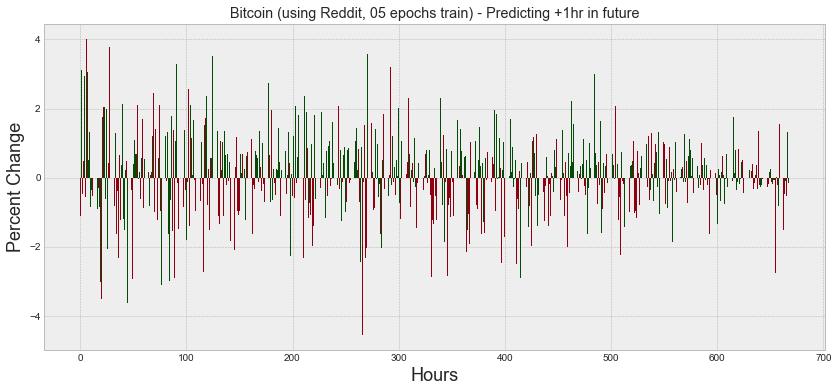

[10 epochs train]


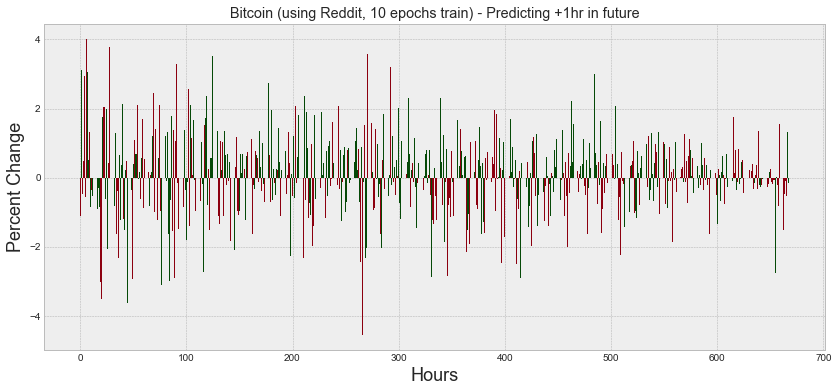

[15 epochs train]


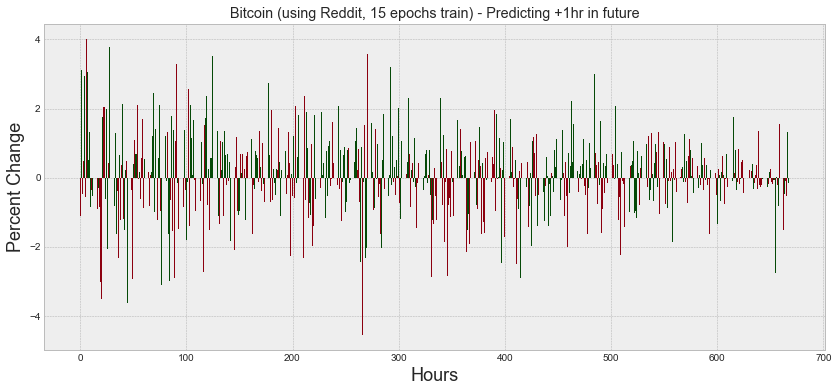

[20 epochs train]


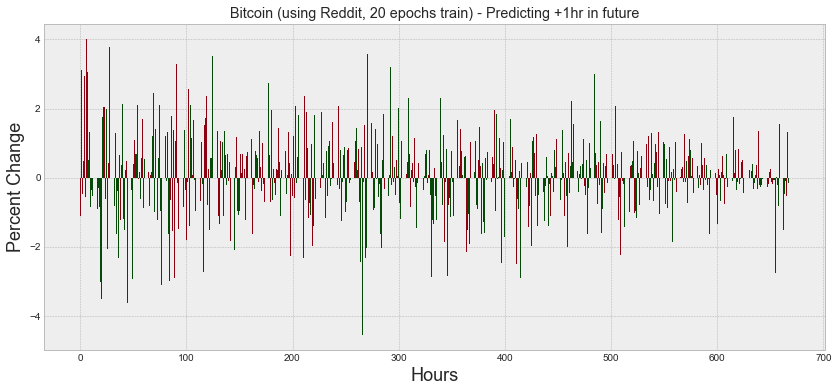

[25 epochs train]


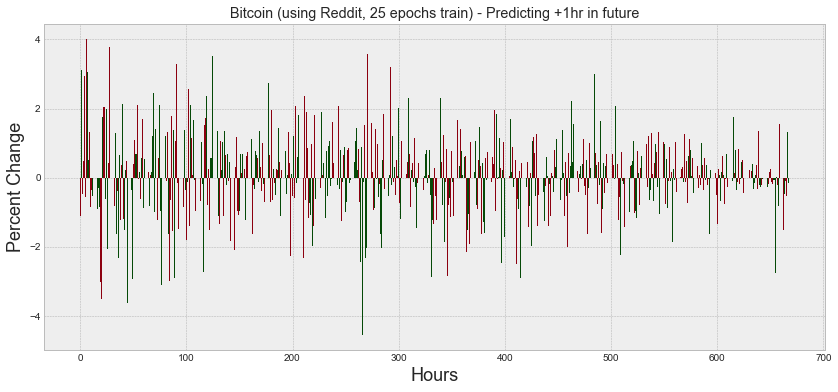

[30 epochs train]


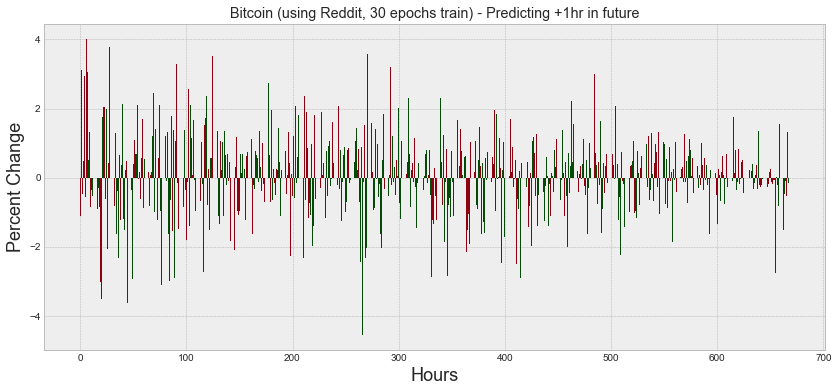

[35 epochs train]


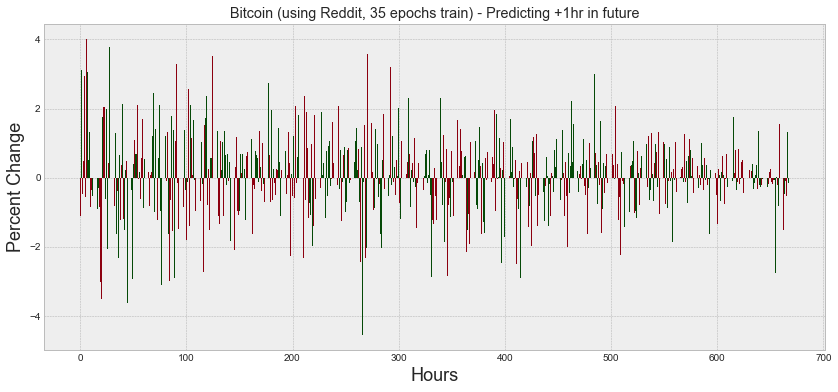

[40 epochs train]


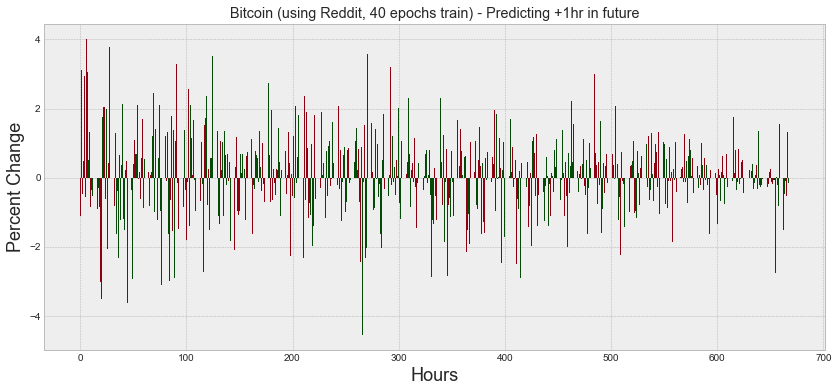

[45 epochs train]


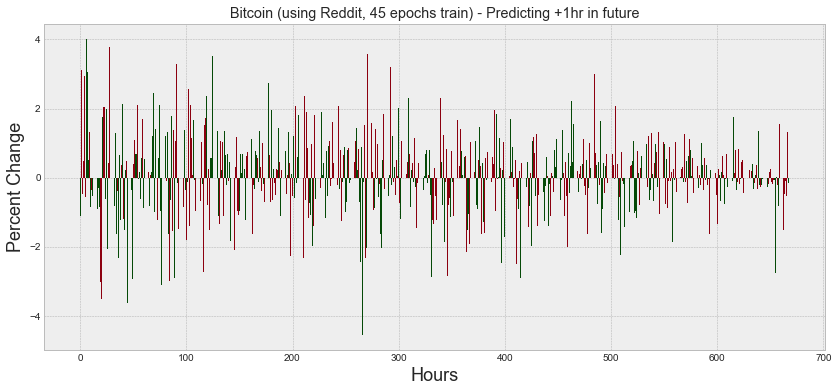

[50 epochs train]


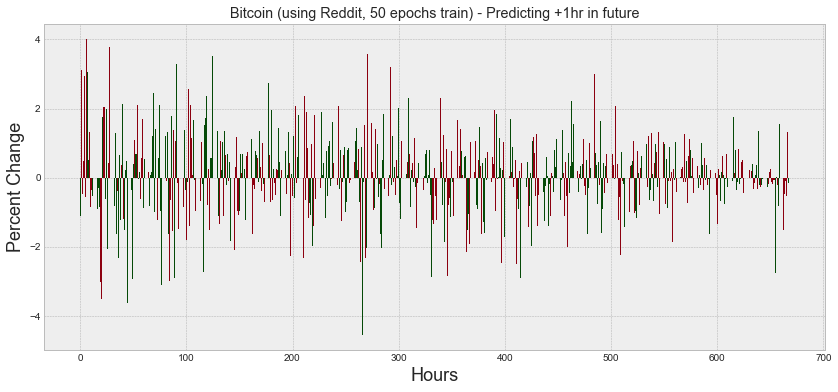


***** PREDICTIONS +2hr IN FUTURE *****
[05 epochs train]


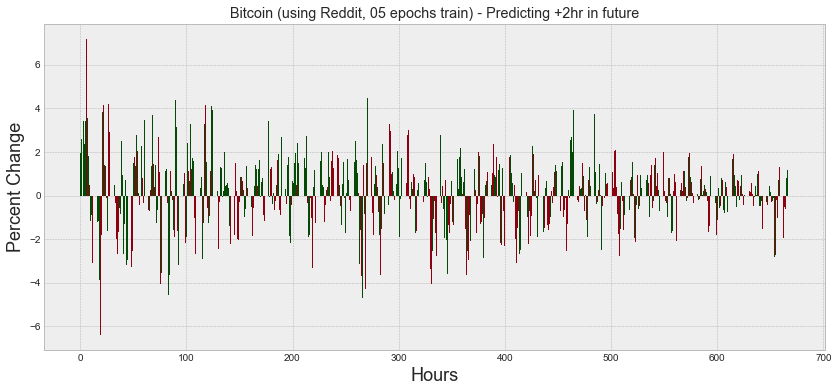

[10 epochs train]


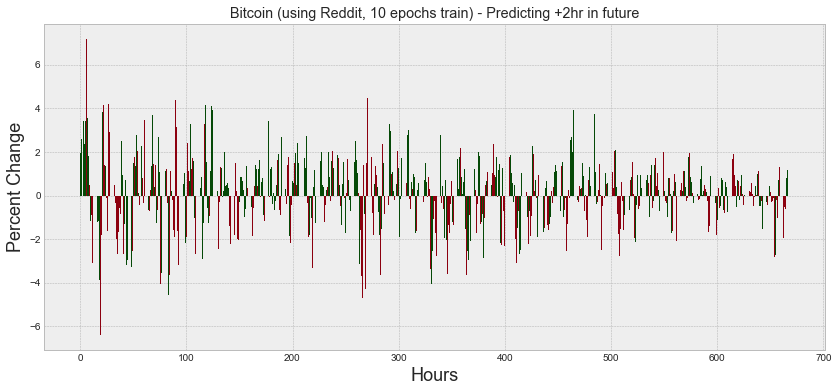

[15 epochs train]


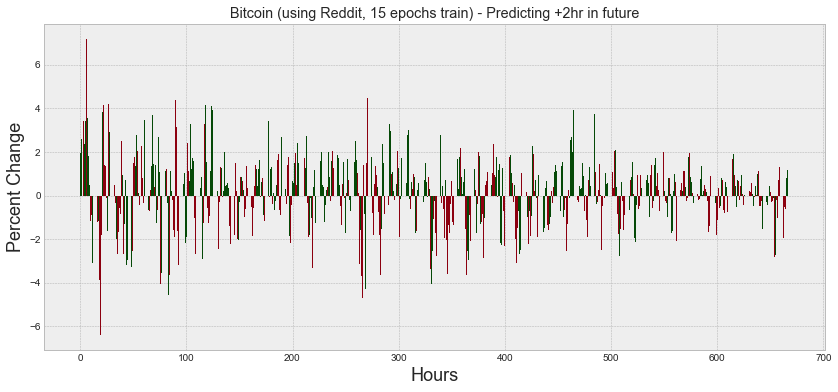

[20 epochs train]


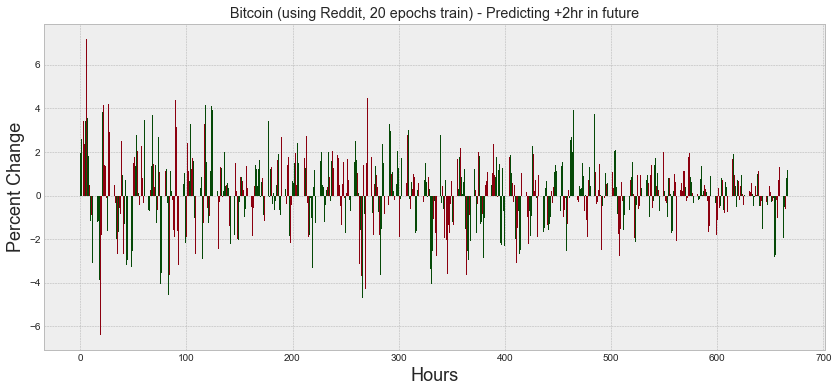

[25 epochs train]


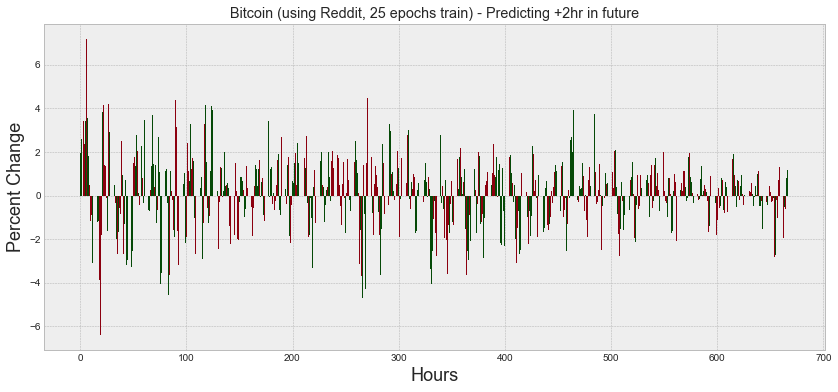

[30 epochs train]


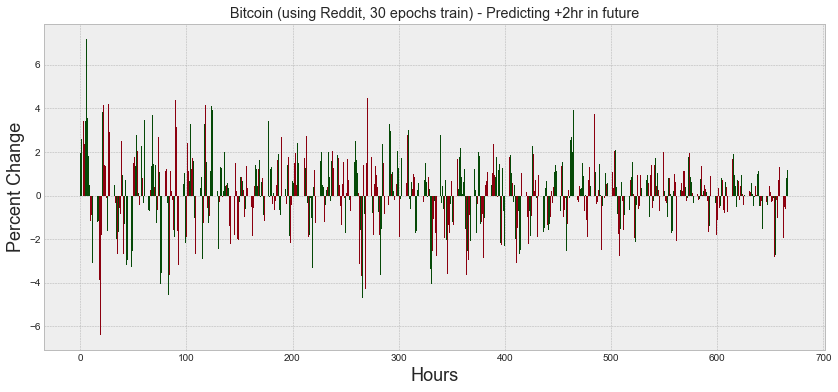

[35 epochs train]


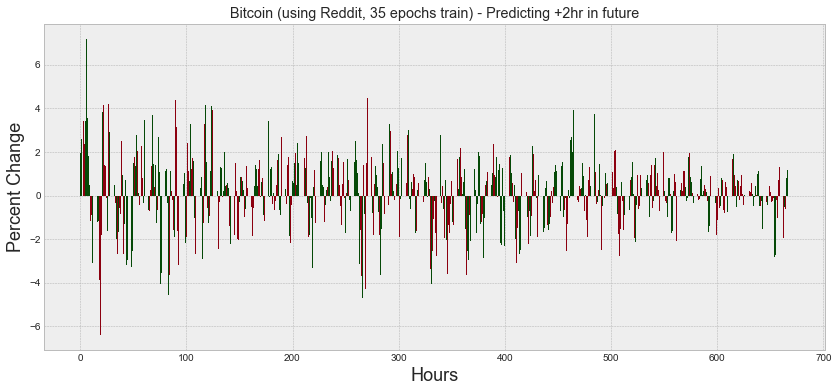

[40 epochs train]


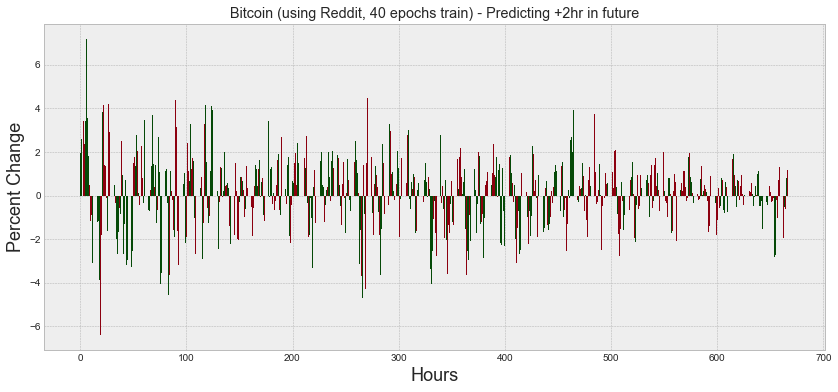

[45 epochs train]


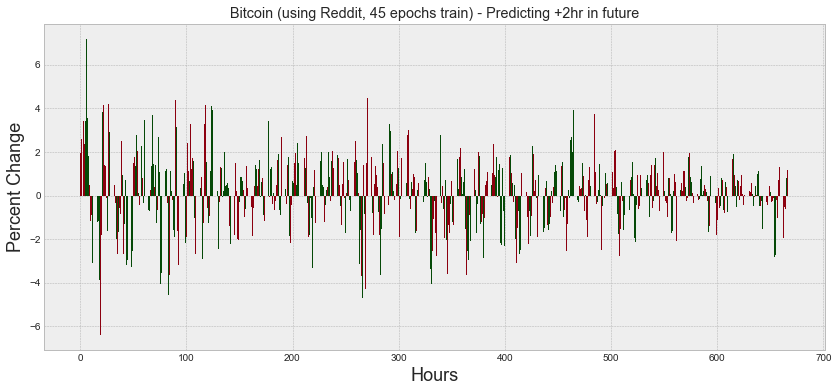

[50 epochs train]


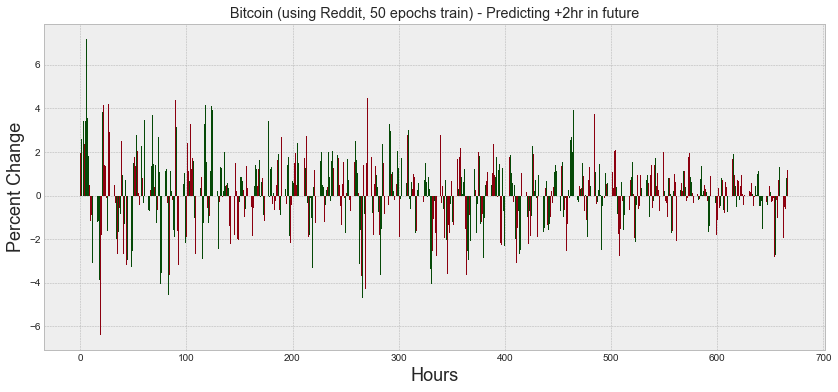


***** PREDICTIONS +6hr IN FUTURE *****
[05 epochs train]


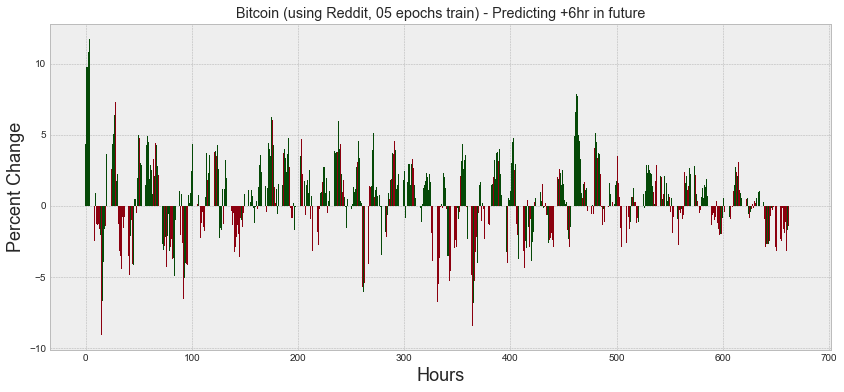

[10 epochs train]


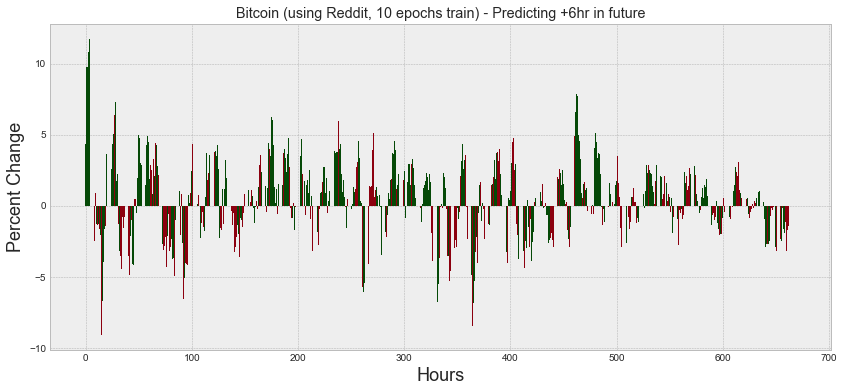

[15 epochs train]


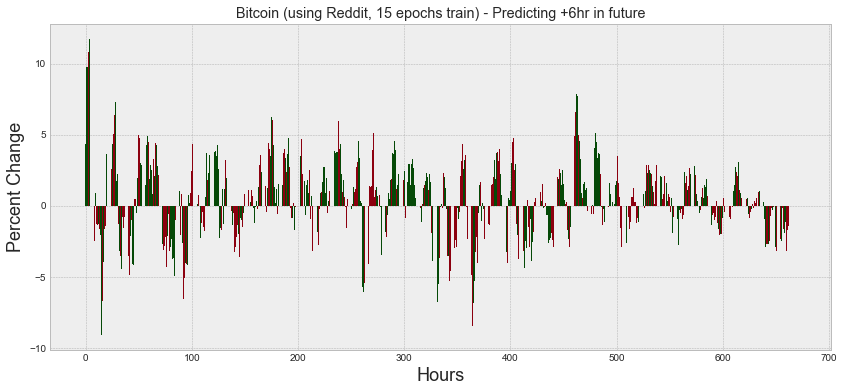

[20 epochs train]


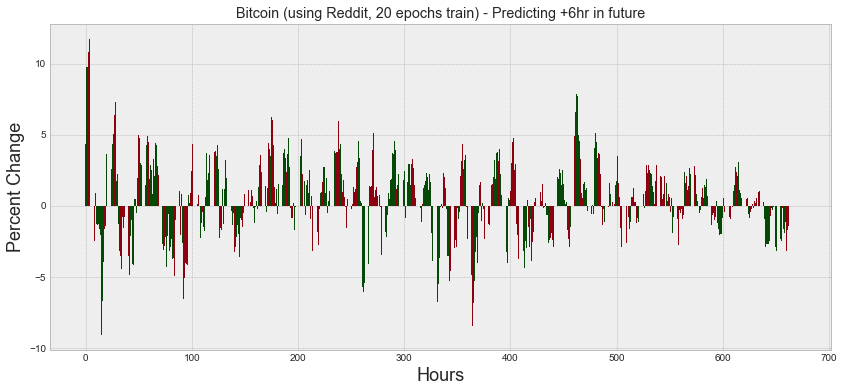

[25 epochs train]


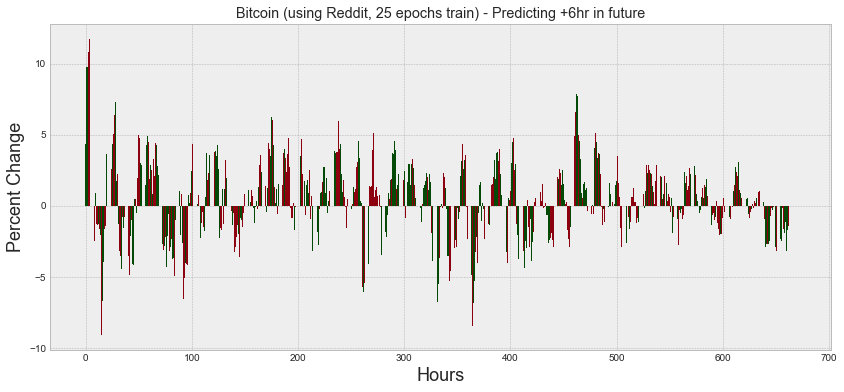

[30 epochs train]


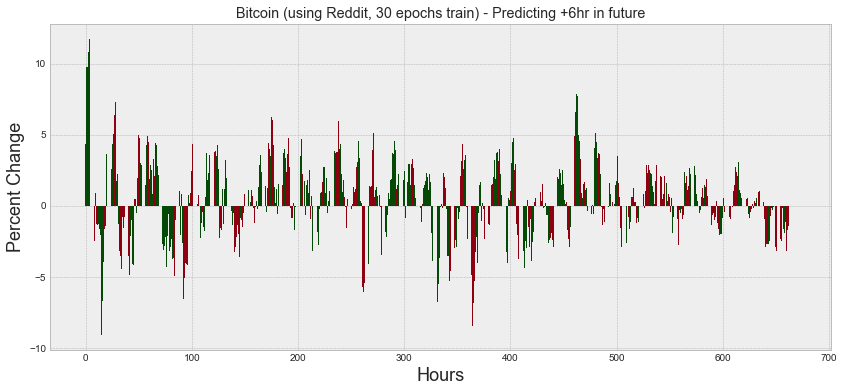

[35 epochs train]


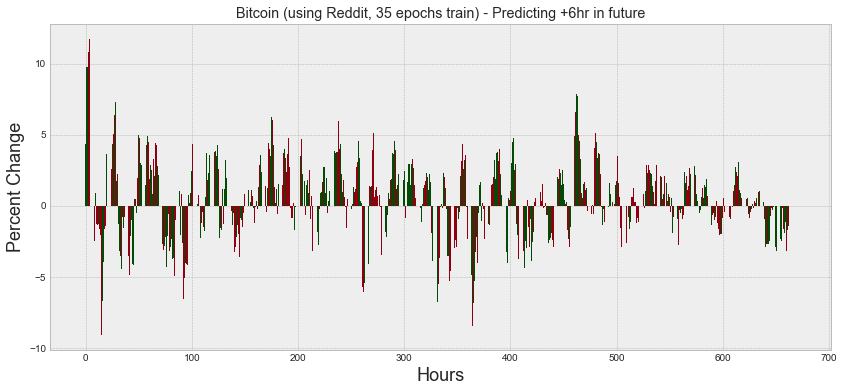

[40 epochs train]


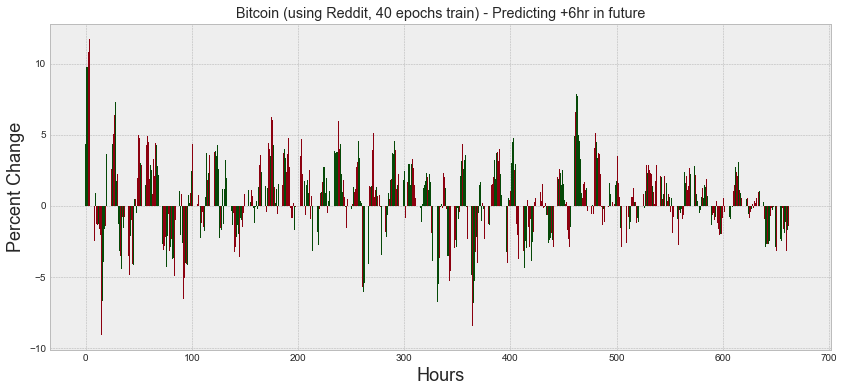

[45 epochs train]


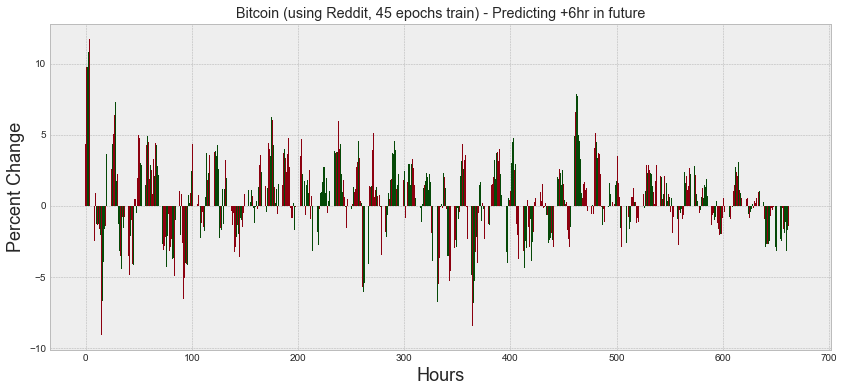

[50 epochs train]


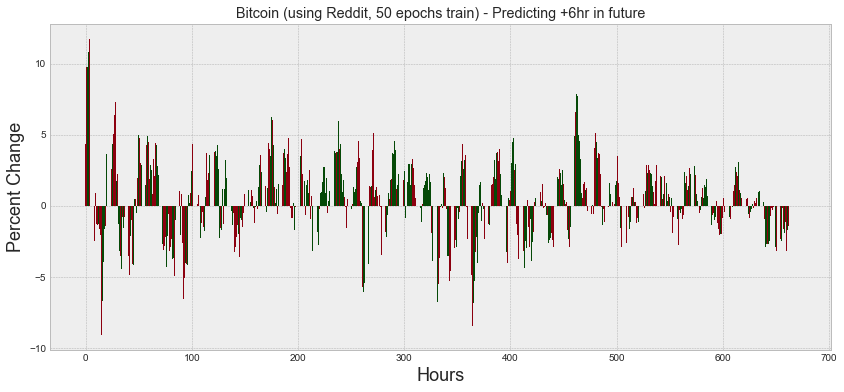


***** PREDICTIONS +12hr IN FUTURE *****
[05 epochs train]


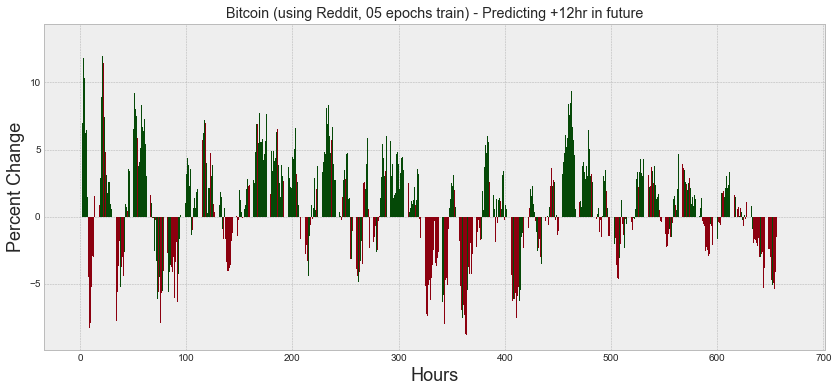

[10 epochs train]


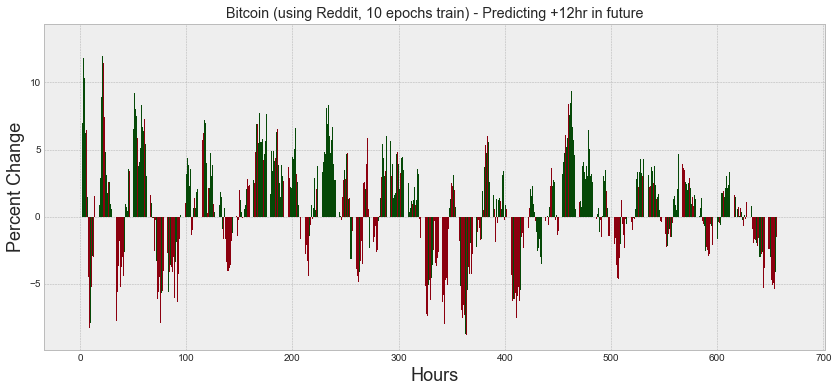

[15 epochs train]


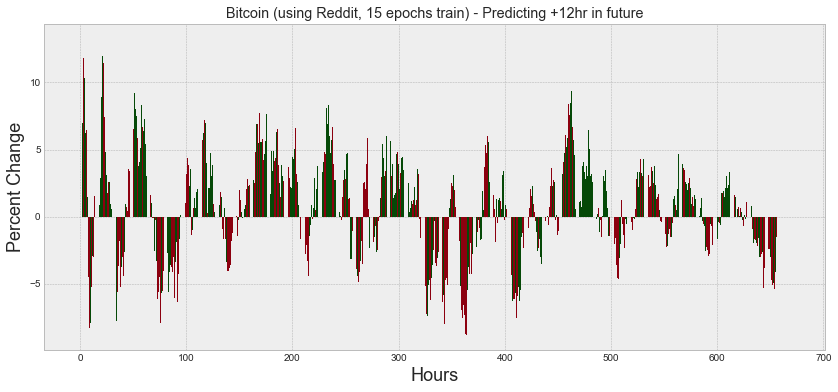

[20 epochs train]


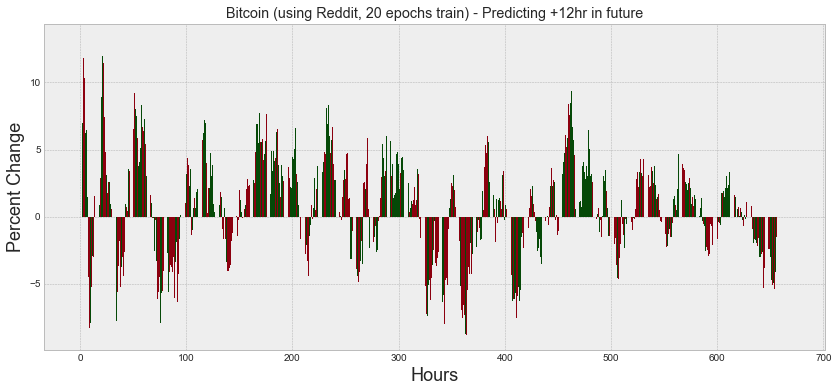

[25 epochs train]


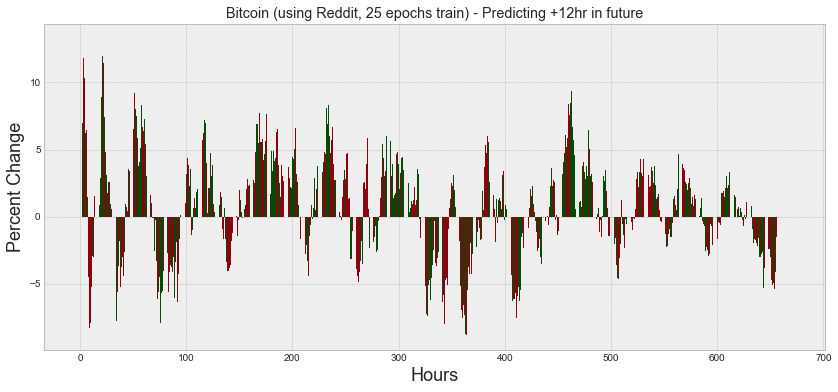

[30 epochs train]


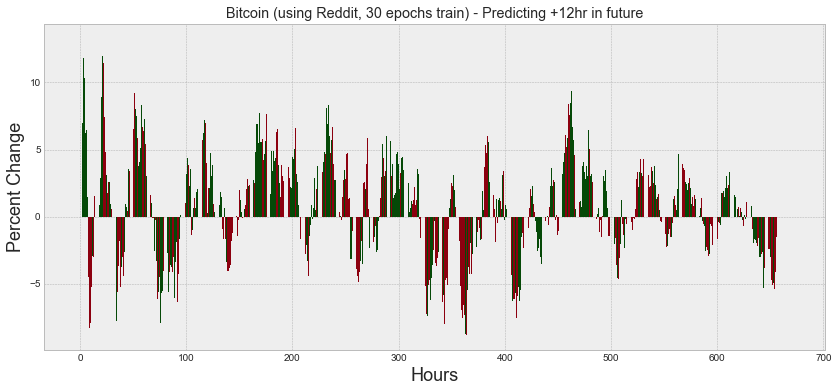

[35 epochs train]


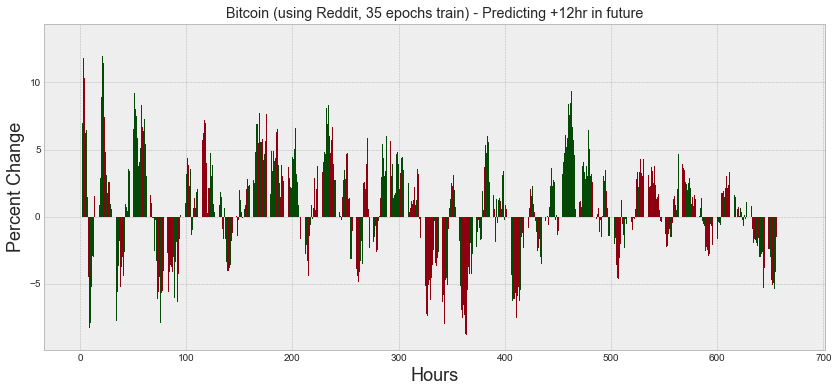

[40 epochs train]


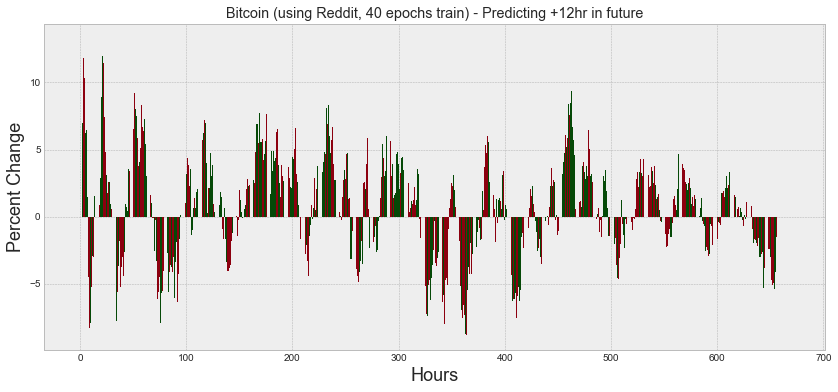

[45 epochs train]


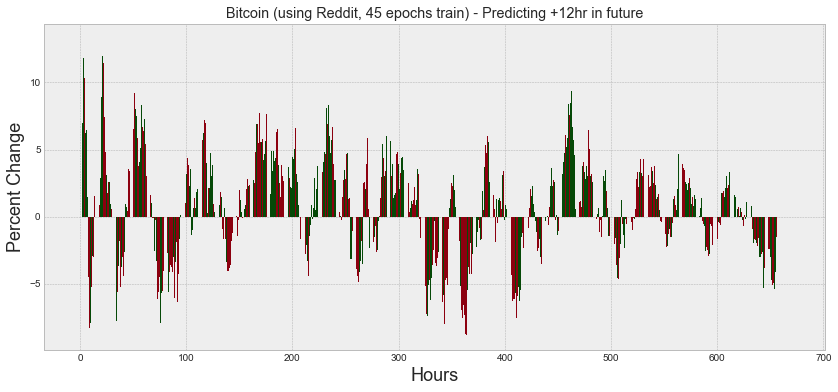

[50 epochs train]


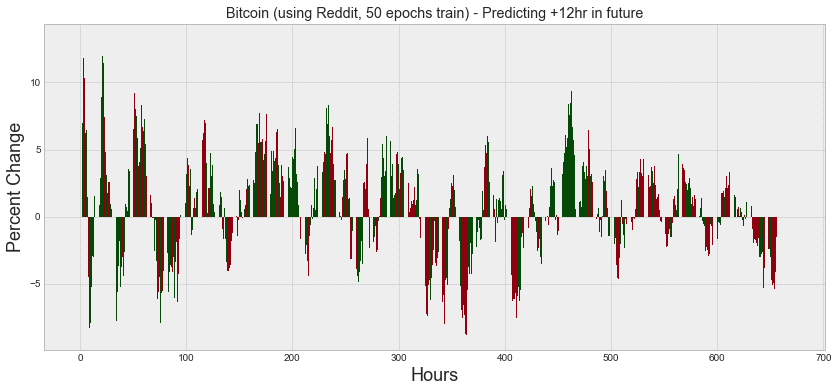


***** PREDICTIONS +24hr IN FUTURE *****
[05 epochs train]


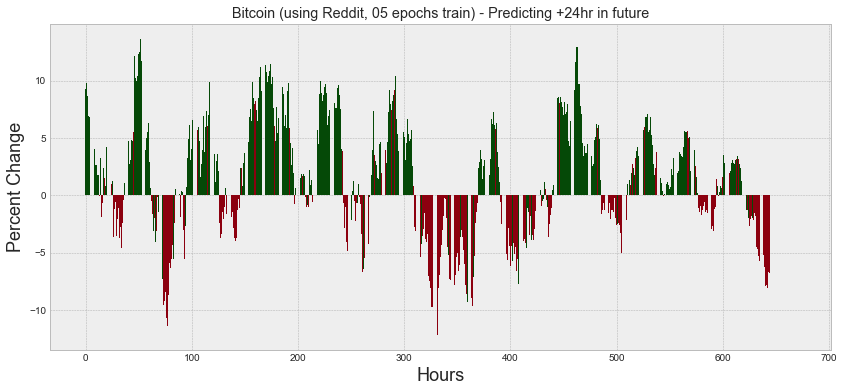

[10 epochs train]


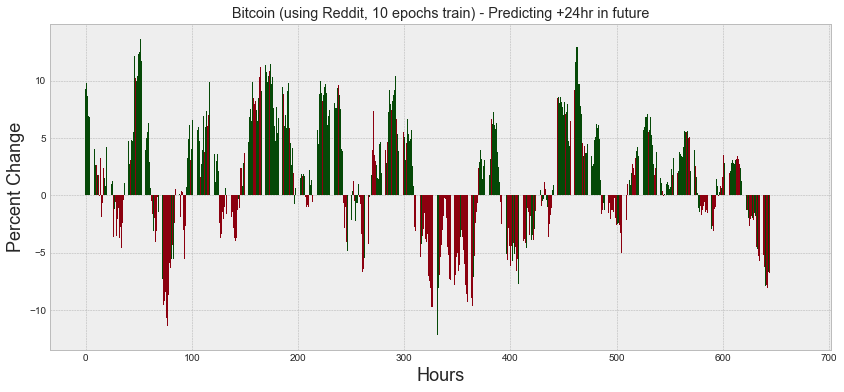

[15 epochs train]


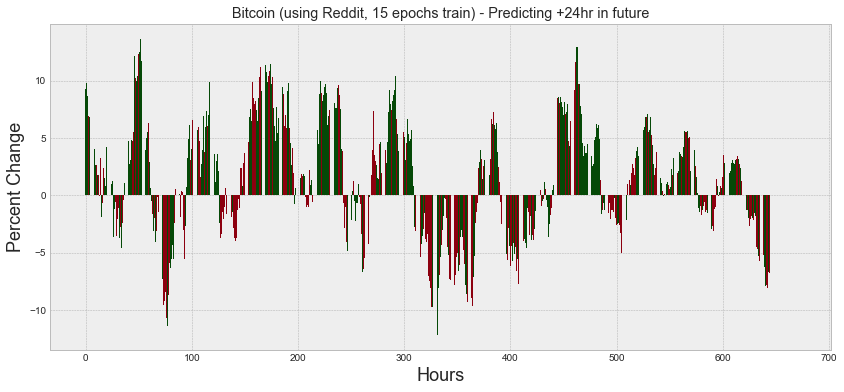

[20 epochs train]


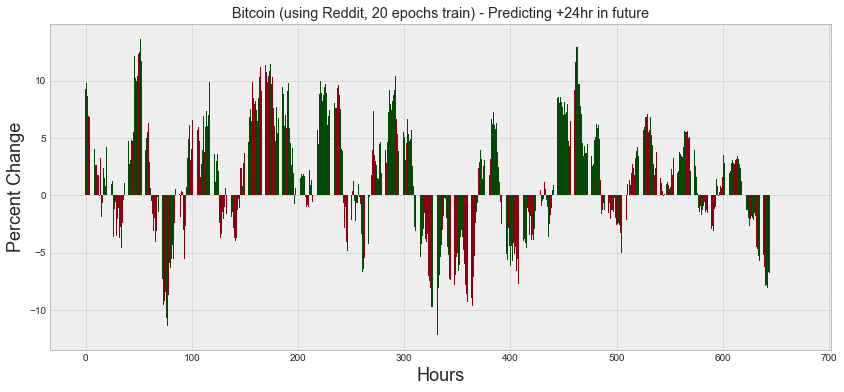

[25 epochs train]


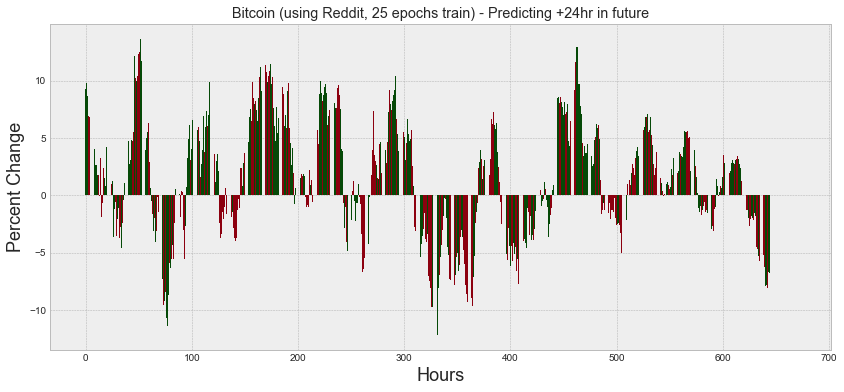

[30 epochs train]


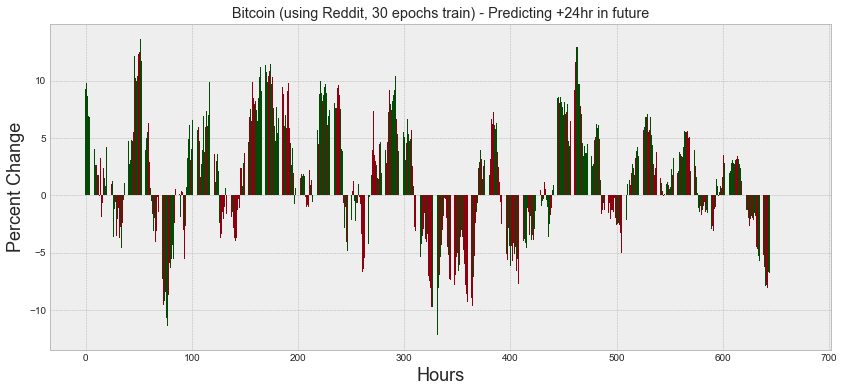

[35 epochs train]


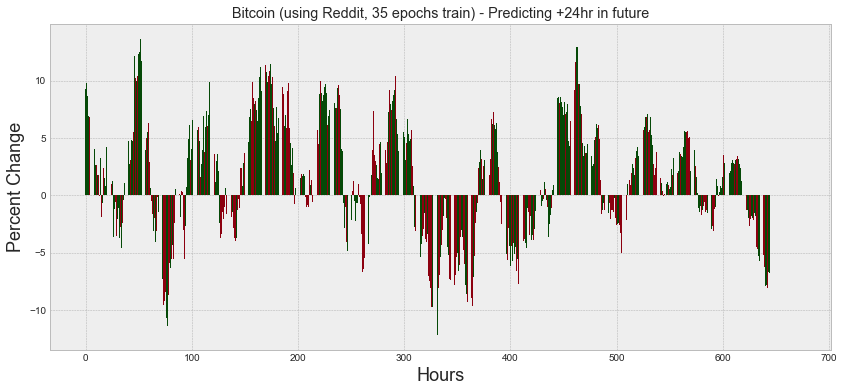

[40 epochs train]


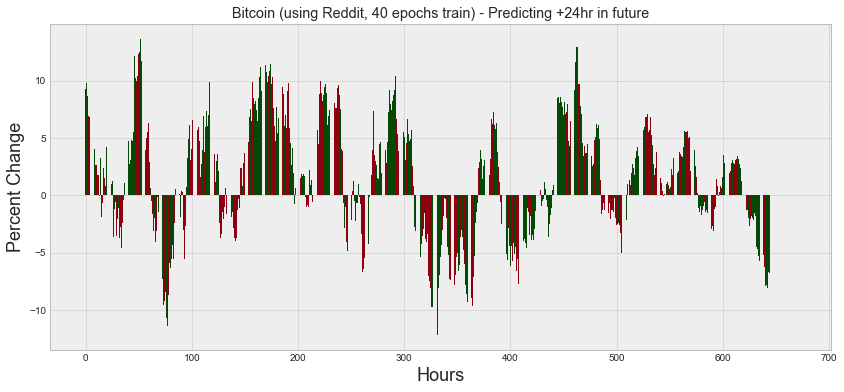

[45 epochs train]


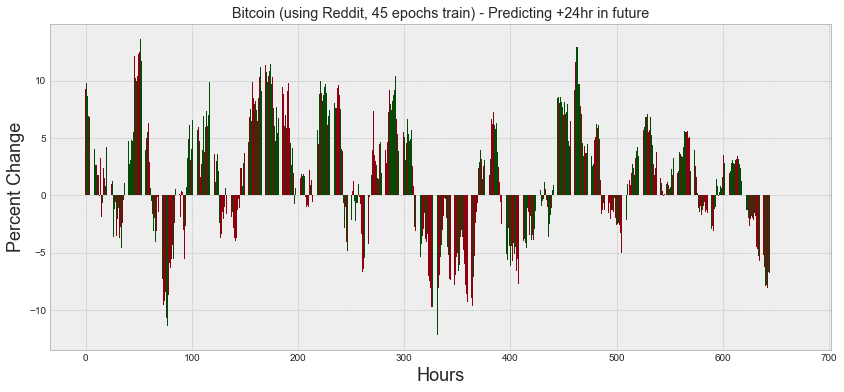

[50 epochs train]


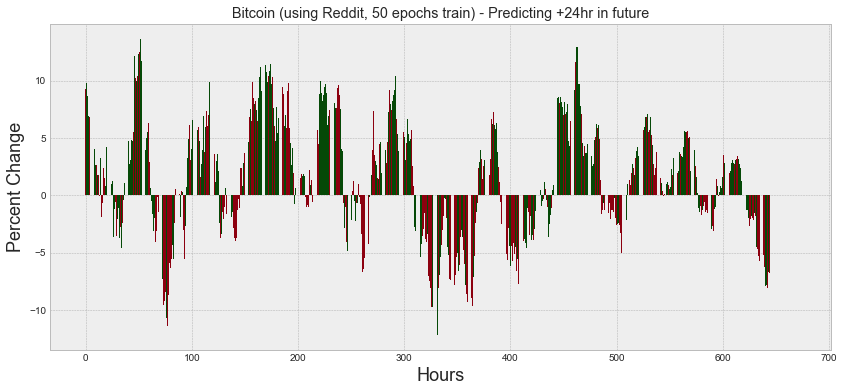

In [37]:
def plot_predicted_changes(changes, title):
        colors = ['xkcd:crimson', 'xkcd:darkgreen']
        pred_colors = []
        percent_changes = []
        for change in changes:
            price_change, pred = change
            if price_change > 0:
                if pred > 0:  # correct
                    percent_changes.append(price_change)
                    pred_colors.append(colors[1])
                else:  # incorrect
                    percent_changes.append(price_change)
                    pred_colors.append(colors[0])
            else:
                if pred < 0:  # correct
                    percent_changes.append(price_change)
                    pred_colors.append(colors[1])
                else:
                    percent_changes.append(price_change)
                    pred_colors.append(colors[0])

        plt.style.use('bmh')
        plt.figure(figsize=(14, 6))
        plt.title('{}'.format(title))
        plt.bar(range(len(percent_changes)), percent_changes, color=pred_colors)
        plt.ylabel('Percent Change', size=18)
        plt.xlabel('Hours', size=18)
        plt.show()

# Loop through each possible chart
for time in prediction_times:
    print ('\n***** PREDICTIONS +%s IN FUTURE *****' % time)
    for epoch in epochs:
        print ('[%s train]' % epoch)
        change = changes[time][epoch] 
        title = 'Bitcoin (using Reddit, %s train) - Predicting +%s in future' % (epoch, time)
        plot_predicted_changes(change, title)
        